<div style ="width:100%">
    <div style="width:80%; background-color:blue; text-align:center; margin:auto
                ;color: white; font-size:30px">
        <strong> Houses prices Prediction </strong>
    </div>
</div>

Dans ce notebook différents modeles sont testés sur les données sélectionnées. <br>
- La selection des des variables (**Feature selection**) est basée sur une annova-1 pour les variables qualitatives, et sur la corrélation pour les variables quantitatives. Le DataSet comprend au total 63 variables explicatives. Intégrer toutes les variables donnent un meilleur modèle, mais ça très couteux en temps de calcul. De plus, l'objectif du projet est la prévision. Devoir remplir donc à chaque un formulaire de 63 champs pour avoir une prévision serait beaucoup trop fastideux. Pour trouver un compromis entre "bon modèle", et temps de calcul, un sous-ensemble de 20 variables sera sélectionné <br>
- Dans la partie modélisation, différents modèles seront testés sur le subset choisi. Il s'agira principalement de **régression simple**, de méthodes **Bagging**, et de **Boosting** <br>
- Une compararison des modèles sera ensuite faite à la fin pour choisir le modèle à déployer <br>
**1. Feature Selection** <br>
**2. Modélisation** <br>
**3. Comparaison des modèles et choix du meilleur modèle** <br>
**4. Déploiement**

In [195]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt 
import json
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             max_error,
                            )
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, r_regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import warnings
warnings.filterwarnings("ignore")

**Définition des fonctions à utiliser**

In [196]:
def get_all_performances(value_train: tuple,
                         values_test: tuple,
                         metrics: list,
                        ) -> pd.DataFrame:

    test_perfs = []
    train_perfs = []
    metric_names = []
    for metric_func in metrics:
        metric_name = metric_func.__name__
        metric_names.append(metric_name)
        train_perfs.append(metric_func(*value_train))
        test_perfs.append(metric_func(*values_test))
    perfs = {"metric": metric_names, "train": train_perfs, "test": test_perfs,}
    return pd.DataFrame(perfs)

METRICS = [r2_score,
           mean_squared_error,
           mean_absolute_percentage_error,
           max_error,
          ]

In [197]:
def get_input_features(model_pipeline, cat_step_name):
    """ Get model feature names used in training
    
    """

    all_feature_names = []

    for step_name, pipe_trans, feat_names in reg_res["preprocessor"].transformers_:
        if step_name == cat_step_name:
            all_feature_names.extend(pipe_trans
                                 .named_steps["encoder"]
                                 .get_feature_names_out(input_features=var_quali)
                                )
        else:
            all_feature_names.extend(feat_names)
    return all_feature_names

# 1. Feature selection

In [198]:
def feature_select(k=7):
    # Sélectionnez les k meilleures variables quantitatives
    global train
    X = train[var_quant]
    y = train[['ln_y']]
    Kbest_quanti = SelectKBest(r_regression, k=k).fit(X, y)

    # Obtenez les noms des colonnes sélectionnées par SelectKBest
    selected_quanti_columns = X.columns[Kbest_quanti.get_support()].tolist()

    # Itération sur les colonnes qualitatives
    value_F = []
    value_p = []
    for col in var_quali:
        # Formule de l'ANOVA
        formula = f'ln_y ~ {col}'

        # Ajustez le modèle
        model = ols(formula, data=train).fit()

        # Récupérez la F-value et p-value
        value_F.append(model.fvalue)
        value_p.append(model.f_pvalue)

    # Affichez les résultats
    anova_res = pd.DataFrame({"variable": var_quali, "F_value": value_F, "p_value": value_p})
    # Sélectionnez les k meilleures variables qualitatives
    Kbest_quali = anova_res.sort_values(by='p_value').head(20 - k).variable.tolist()

    # Sélectionnez les colonnes finales
    selected_columns = selected_quanti_columns + Kbest_quali + ['ln_y']
    
    # Filtrer le DataFrame avec les colonnes sélectionnées
    res = train[selected_columns]
    return res

In [199]:
with open("../data/data_types.json", "r") as f:
    types_serializable = json.load(f)

# Importation du DataFrame depuis le fichier CSV
train = pd.read_csv("../data/final_train.csv")

# Ajuster les types de données du DataFrame
train = train.astype(types_serializable)

In [200]:
train.head(3)

,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,...,ScreenPorch,PoolArea,Fence,MiscVal,YrSold,SaleType,SaleCondition,GarageYrBlt_2,MoSold_2,ln_y
0,60,RL,8450,Reg,Lvl,Inside,CollgCr,Norm,1Fam,2Story,...,0,0,No_Fence,0,2008,WD,Normal,2000_plus,Janvier_Mars,12.247694
1,20,RL,9600,Reg,Lvl,FR2,Veenker,Feedr,1Fam,1Story,...,0,0,No_Fence,0,2007,WD,Normal,1950_1980,Avril_Juin,12.109011
2,60,RL,11250,IR1,Lvl,Inside,CollgCr,Norm,1Fam,2Story,...,0,0,No_Fence,0,2008,WD,Normal,2000_plus,Juillet_Septembre,12.317167


In [201]:
var_quant = train.drop(['ln_y'], axis = 1).select_dtypes(include=['int','float']).columns.tolist()
var_quali = train.select_dtypes(include=['object','bool']).columns.tolist()

In [202]:
train = feature_select()
train.head(3)

,YearBuilt,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,GarageCars,GarageArea,OverallQual,Neighborhood,ExterQual,...,KitchenQual,GarageFinish,GarageType,MSSubClass,FireplaceQu,Foundation,GarageYrBlt_2,HeatingQC,BsmtFinType1,ln_y
0,2003,856,856,1710,2,2,548,7,CollgCr,Gd,...,Gd,RFn,Attchd,60,No_FirePlace,PConc,2000_plus,Ex,GLQ,12.247694
1,1976,1262,1262,1262,2,2,460,6,Veenker,TA,...,TA,RFn,Attchd,20,TA,CBlock,1950_1980,Ex,ALQ,12.109011
2,2001,920,920,1786,2,2,608,7,CollgCr,Gd,...,Gd,RFn,Attchd,60,TA,PConc,2000_plus,Ex,GLQ,12.317167


In [203]:
var_quant = train.drop(['ln_y'], axis = 1).select_dtypes(include=['int','float']).columns.tolist()
var_quali = train.select_dtypes(include=['object','bool']).columns.tolist()

In [204]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(['ln_y'], axis=1),
                                                    train[['ln_y']],
                                                    test_size=0.25, random_state=30)

# 2. Modélisation

In [205]:
model = []
train_r2 = []
test_r2 = []

## 2.1 Régressions linéaires

### 2.1.1 Régression linéaire simple

In [206]:
quant_transform = Pipeline(steps=[("scaler", StandardScaler())]
                              )

quali_transform = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))]
                              )


preprocessor = ColumnTransformer(
    transformers=[
        ("num", quant_transform, var_quant),
        ("cat", quali_transform, var_quali),
    ]
)

# Append regressor to preprocessing pipeline.
# Now we have a full prediction pipeline.
reg = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())]
)

param_grid = {
    "regressor__fit_intercept": [True, False],
}

grid_search = GridSearchCV(reg, param_grid, cv=10, scoring="r2", return_train_score=True) # r2
# you can see the list of key for scoring: sorted(sklearn.metrics.SCORERS.keys())
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['YearBuilt',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'FullBath',
                                                                          'GarageCars',
                                                                          'GarageArea']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['OverallQual',
                                                                          'Neighborhood',
                                                                          'ExterQual',
                                                                          'BsmtQual',
                                                                          'KitchenQual',
                                                                          'GarageFinish',
                                                                          'GarageType',
                                                                          'MSSubClass',
                                                                          'FireplaceQu',
                                                                          'Foundation',
                                                                          'GarageYrBlt_2',
                                                                          'HeatingQC',
                                                                          'BsmtFinType1'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'regressor__fit_intercept': [True, False]},
             return_train_score=True, scoring='r2')

In [207]:
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__fit_intercept': True}


In [208]:
best_model = grid_search.best_estimator_

In [209]:
performances = get_all_performances(value_train=(y_train, grid_search.predict(X_train)),
                     values_test=(y_test, grid_search.predict(X_test)),
                     metrics=METRICS
                    )
model.append("Regression Linéaire")
train_r2.append(np.round(performances['train'][0], 4))
test_r2.append(np.round(performances['test'][0], 4))

performances

,metric,train,test
0,r2_score,0.886694,0.862208
1,mean_squared_error,0.017874,0.022457
2,mean_absolute_percentage_error,0.007815,0.008932
3,max_error,1.172869,0.880013


### Feature Importance

In [210]:
reg_res = grid_search.best_estimator_
model_features = get_input_features(model_pipeline=reg, cat_step_name="cat")

In [211]:
df_feature_importance = pd.DataFrame(reg_res[-1].coef_.T, columns=["coef"], index=model_features)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

Shape: (109, 1)


,coef
YearBuilt,0.023885
TotalBsmtSF,-0.012373
1stFlrSF,0.004928
GrLivArea,0.105942
FullBath,0.025081


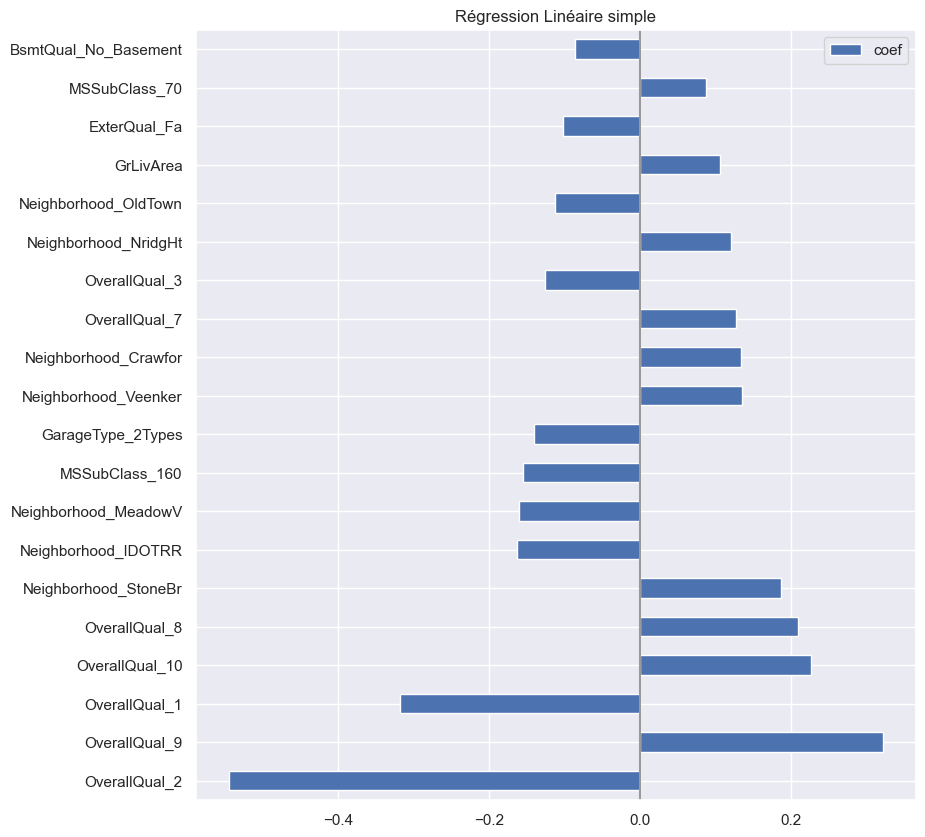

In [212]:
# top 20 most important features
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending=False)
 .head(20)
 .plot(kind="barh", figsize=(12, 10))
)
plt.title("Régression Linéaire simple")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3);

### 2.1.2 Régression Lasso

In [213]:
lasso_regressor = Lasso()
reg.set_params(regressor=lasso_regressor)

param_grid = {
    "regressor__alpha": [0.01, 0.05, 0.07,0.1],
}

grid_search = GridSearchCV(reg, param_grid, cv=10, scoring="r2", return_train_score=True) # r2
# you can see the list of key for scoring: sorted(sklearn.metrics.SCORERS.keys())
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['YearBuilt',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'FullBath',
                                                                          'GarageCars',
                                                                          'GarageArea']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['OverallQual',
                                                                          'Neighborhood',
                                                                          'ExterQual',
                                                                          'BsmtQual',
                                                                          'KitchenQual',
                                                                          'GarageFinish',
                                                                          'GarageType',
                                                                          'MSSubClass',
                                                                          'FireplaceQu',
                                                                          'Foundation',
                                                                          'GarageYrBlt_2',
                                                                          'HeatingQC',
                                                                          'BsmtFinType1'])])),
                                       ('regressor', Lasso())]),
             param_grid={'regressor__alpha': [0.01, 0.05, 0.07, 0.1]},
             return_train_score=True, scoring='r2')

In [214]:
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best params: {best_params}")

Best params: {'regressor__alpha': 0.01}


In [215]:
performances = get_all_performances(value_train=(y_train, grid_search.predict(X_train)),
                     values_test=(y_test, grid_search.predict(X_test)),
                     metrics=METRICS
                    )
model.append("Regression Lasso")
train_r2.append(np.round(performances['train'][0], 4))
test_r2.append(np.round(performances['test'][0], 4))

performances

,metric,train,test
0,r2_score,0.784953,0.811461
1,mean_squared_error,0.033923,0.030728
2,mean_absolute_percentage_error,0.010311,0.010570
3,max_error,2.054750,0.978605


In [216]:
reg_res = grid_search.best_estimator_
model_features = get_input_features(model_pipeline=reg, cat_step_name="cat")

In [217]:
df_feature_importance = pd.DataFrame(reg_res[-1].coef_.T, columns=["coef"], index=model_features)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

Shape: (109, 1)


,coef
YearBuilt,0.078951
TotalBsmtSF,0.053874
1stFlrSF,0.000000
GrLivArea,0.141844
FullBath,0.014985


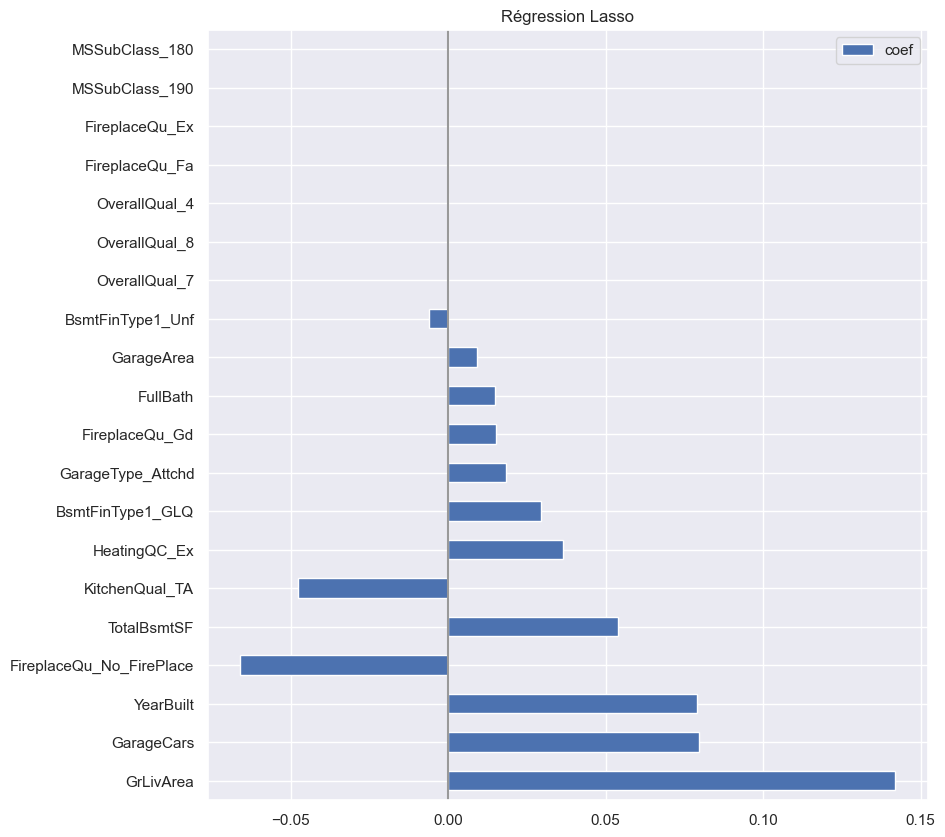

In [218]:
# top 20 most important features
(df_feature_importance
 .sort_values("coef", key=lambda v: abs(v), ascending = False)
 .head(20)
 .plot(kind="barh", figsize=(12, 10))
)
plt.title("Régression Lasso")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3);

## 2.2 Bagging

### 2.2.1 RandomForest

In [219]:
RF_regressor = RandomForestRegressor()
reg.set_params(regressor=RF_regressor)

param_grid = {
}

grid_search = GridSearchCV(reg, param_grid, cv=10, scoring="r2", return_train_score=True) # r2
# you can see the list of key for scoring: sorted(sklearn.metrics.SCORERS.keys())
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['YearBuilt',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'FullBath',
                                                                          'GarageCars',
                                                                          'GarageArea']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['OverallQual',
                                                                          'Neighborhood',
                                                                          'ExterQual',
                                                                          'BsmtQual',
                                                                          'KitchenQual',
                                                                          'GarageFinish',
                                                                          'GarageType',
                                                                          'MSSubClass',
                                                                          'FireplaceQu',
                                                                          'Foundation',
                                                                          'GarageYrBlt_2',
                                                                          'HeatingQC',
                                                                          'BsmtFinType1'])])),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={}, return_train_score=True, scoring='r2')

In [220]:
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
#print(f"Best params: {best_params}")

performances = get_all_performances(value_train=(y_train, grid_search.predict(X_train)),
                     values_test=(y_test, grid_search.predict(X_test)),
                     metrics=METRICS
                    )
model.append("Random Forest")
train_r2.append(np.round(performances['train'][0], 4))
test_r2.append(np.round(performances['test'][0], 4))

performances

,metric,train,test
0,r2_score,0.979271,0.842814
1,mean_squared_error,0.003270,0.025618
2,mean_absolute_percentage_error,0.003214,0.009243
3,max_error,0.392182,0.983821


In [221]:
reg_res = grid_search.best_estimator_
model_features = get_input_features(model_pipeline=reg, cat_step_name="cat")

In [222]:
df_feature_importance = pd.DataFrame(reg_res[-1].feature_importances_, columns=["Importance"], index=model_features)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

Shape: (109, 1)


,Importance
YearBuilt,0.240921
TotalBsmtSF,0.084496
1stFlrSF,0.036378
GrLivArea,0.303657
FullBath,0.033170


Text(0.5, 1.0, 'Random Forest')

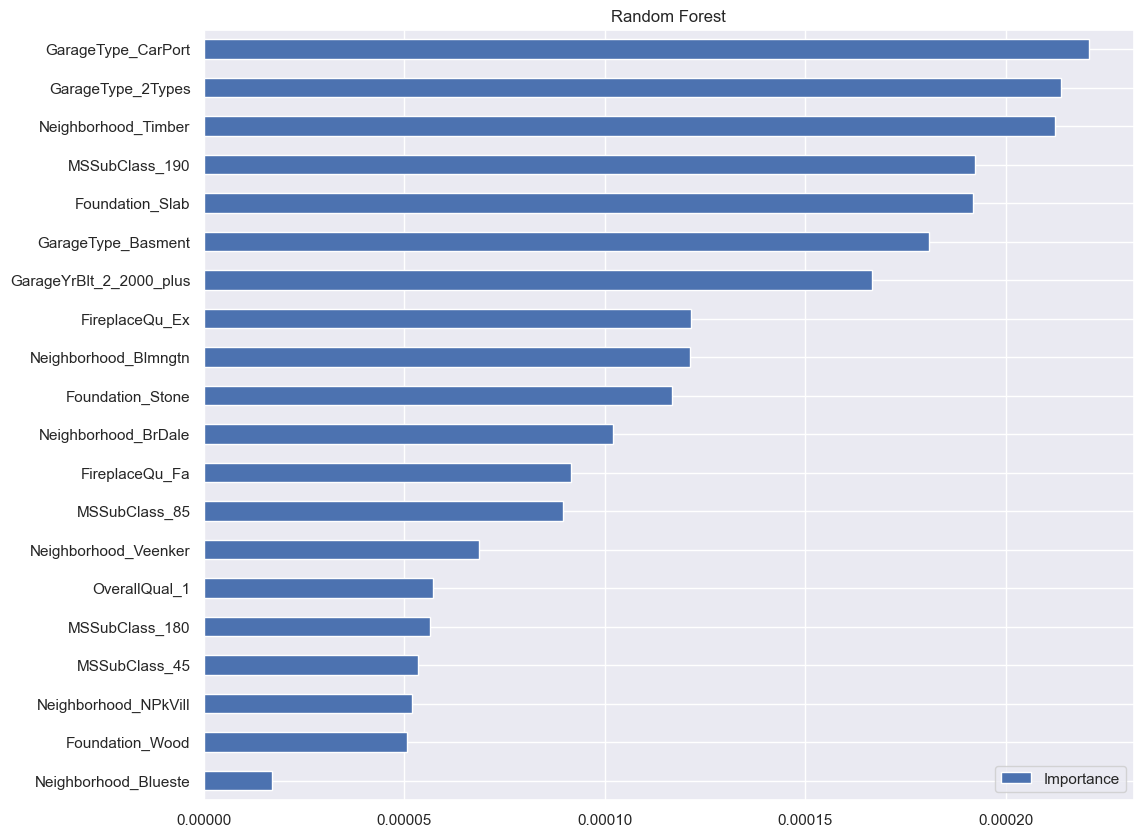

In [223]:
(df_feature_importance
 .sort_values("Importance")
 .head(20)
 .plot(kind="barh", figsize=(12, 10))
)
plt.title("Random Forest")

## 2.3 Boosting

### 2.3.1 XGBOOST

In [224]:
xgb_regressor = XGBRegressor()
reg.set_params(regressor=xgb_regressor)

param_grid = {
    "regressor__n_estimators": [ 300,400,500]
}

grid_search = GridSearchCV(reg, param_grid, cv=10, scoring="r2", return_train_score=True) # r2
# you can see the list of key for scoring: sorted(sklearn.metrics.SCORERS.keys())
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['YearBuilt',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'FullBath',
                                                                          'GarageCars',
                                                                          'GarageArea']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['OverallQual',
                                                                          'Neighborhood',
                                                                          'ExterQua...
                                                     max_bin=None,
                                                     max_cat_threshold=None,
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=None, ...))]),
             param_grid={'regressor__n_estimators': [300, 400, 500]},
             return_train_score=True, scoring='r2')

In [225]:
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best params: {best_params}")

performances = get_all_performances(value_train=(y_train, grid_search.predict(X_train)),
                     values_test=(y_test, grid_search.predict(X_test)),
                     metrics=METRICS
                    )
model.append("XGBoost")
train_r2.append(np.round(performances['train'][0], 4))
test_r2.append(np.round(performances['test'][0], 4))

performances

Best params: {'regressor__n_estimators': 300}


,metric,train,test
0,r2_score,0.999781,0.810396
1,mean_squared_error,0.000035,0.030902
2,mean_absolute_percentage_error,0.000147,0.010037
3,max_error,0.093642,0.961497


In [226]:
reg_res = grid_search.best_estimator_
model_features = get_input_features(model_pipeline=reg, cat_step_name="cat")

In [227]:
df_feature_importance = pd.DataFrame(reg_res[-1].feature_importances_, columns=["Importance"], index=model_features)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.sort_values(by = 'Importance', ascending = False).head()

Shape: (109, 1)


,Importance
ExterQual_Fa,0.163489
ExterQual_TA,0.145391
KitchenQual_Ex,0.093779
FireplaceQu_No_FirePlace,0.086081
ExterQual_Ex,0.081471


Text(0.5, 1.0, 'XGBoost')

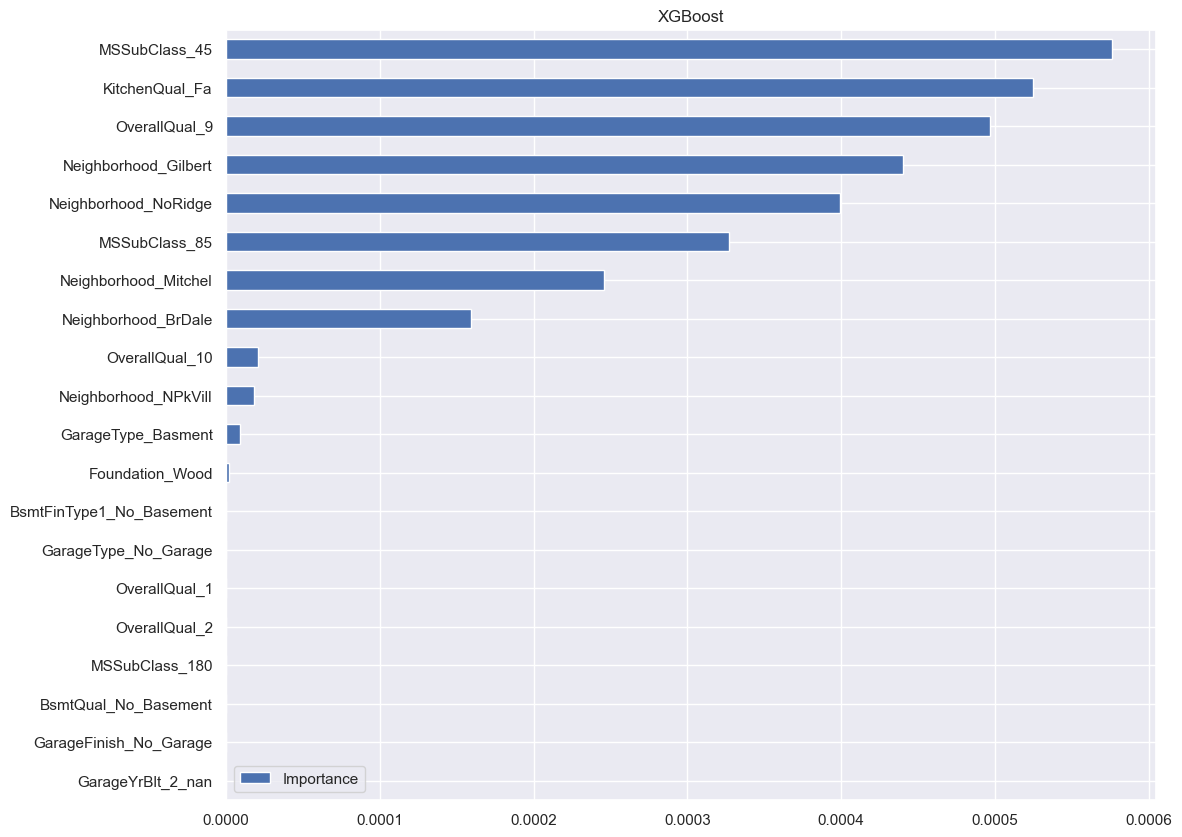

In [228]:
(df_feature_importance
 .sort_values("Importance")
 .head(20)
 .plot(kind="barh", figsize=(12, 10))
)
plt.title("XGBoost")

### 2.3.2 LightGBM

In [229]:
lgb_regressor = LGBMRegressor()
reg.set_params(regressor=lgb_regressor)

param_grid = {
    "regressor__num_leaves": [10, 11, 12, 13, 14, 15]
}

grid_search = GridSearchCV(reg, param_grid, cv=10, scoring="r2", return_train_score=True) # r2
# you can see the list of key for scoring: sorted(sklearn.metrics.SCORERS.keys())
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['YearBuilt',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'FullBath',
                                                                          'GarageCars',
                                                                          'GarageArea']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['OverallQual',
                                                                          'Neighborhood',
                                                                          'ExterQual',
                                                                          'BsmtQual',
                                                                          'KitchenQual',
                                                                          'GarageFinish',
                                                                          'GarageType',
                                                                          'MSSubClass',
                                                                          'FireplaceQu',
                                                                          'Foundation',
                                                                          'GarageYrBlt_2',
                                                                          'HeatingQC',
                                                                          'BsmtFinType1'])])),
                                       ('regressor', LGBMRegressor())]),
             param_grid={'regressor__num_leaves': [10, 11, 12, 13, 14, 15]},
             return_train_score=True, scoring='r2')

In [230]:
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best params: {best_params}")

performances = get_all_performances(value_train=(y_train, grid_search.predict(X_train)),
                     values_test=(y_test, grid_search.predict(X_test)),
                     metrics=METRICS
                    )
model.append("LightGBM")
train_r2.append(np.round(performances['train'][0], 4))
test_r2.append(np.round(performances['test'][0], 4))

performances

Best params: {'regressor__num_leaves': 13}


,metric,train,test
0,r2_score,0.942615,0.842673
1,mean_squared_error,0.009052,0.025641
2,mean_absolute_percentage_error,0.005519,0.009166
3,max_error,0.570580,0.997325


In [231]:
reg_res = grid_search.best_estimator_
model_features = get_input_features(model_pipeline=reg, cat_step_name="cat")

In [232]:
df_feature_importance = pd.DataFrame(reg_res[-1].feature_importances_, columns=["Importance"], index=model_features)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

Shape: (109, 1)


,Importance
YearBuilt,114
TotalBsmtSF,129
1stFlrSF,129
GrLivArea,168
FullBath,14


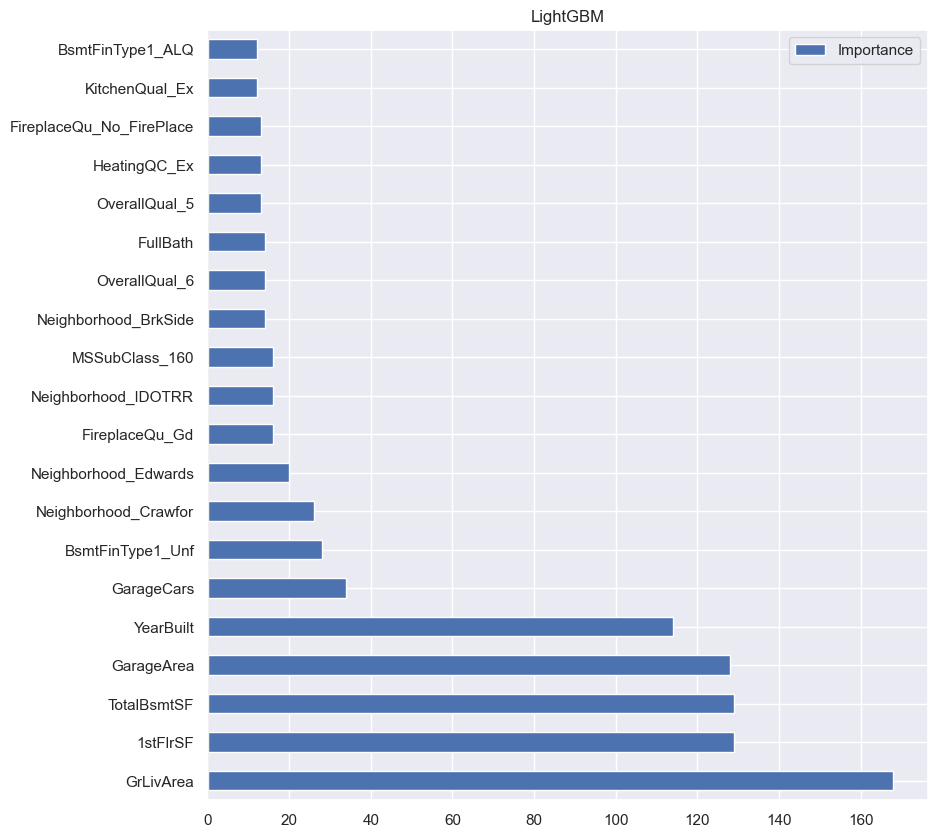

In [233]:
(df_feature_importance
 .sort_values("Importance", key=lambda v: abs(v), ascending = False)
 .head(20)
 .plot(kind="barh", figsize=(12, 10))
)
plt.title("LightGBM")
plt.axvline(x=0, color='.6')
plt.subplots_adjust(left=.3)

### 2.3.3 CatBoost

In [234]:
lgb_regressor = CatBoostRegressor(verbose=False)
reg.set_params(regressor=lgb_regressor)

param_grid = {
    "regressor__learning_rate": [0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(reg, param_grid, cv=10, scoring="r2", return_train_score=True) # r2
# you can see the list of key for scoring: sorted(sklearn.metrics.SCORERS.keys())
grid_search

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['YearBuilt',
                                                                          'TotalBsmtSF',
                                                                          '1stFlrSF',
                                                                          'GrLivArea',
                                                                          'FullBath',
                                                                          'GarageCars',
                                                                          'GarageArea']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['OverallQual',
                                                                          'Neighborhood',
                                                                          'ExterQual',
                                                                          'BsmtQual',
                                                                          'KitchenQual',
                                                                          'GarageFinish',
                                                                          'GarageType',
                                                                          'MSSubClass',
                                                                          'FireplaceQu',
                                                                          'Foundation',
                                                                          'GarageYrBlt_2',
                                                                          'HeatingQC',
                                                                          'BsmtFinType1'])])),
                                       ('regressor',
                                        <catboost.core.CatBoostRegressor object at 0x000002BD4256AB50>)]),
             param_grid={'regressor__learning_rate': [0.05, 0.1, 0.2]},
             return_train_score=True, scoring='r2')

In [235]:
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"Best params: {best_params}")

performances = get_all_performances(value_train=(y_train, grid_search.predict(X_train)),
                     values_test=(y_test, grid_search.predict(X_test)),
                     metrics=METRICS
                    )
model.append("CatBoost")
train_r2.append(np.round(performances['train'][0], 4))
test_r2.append(np.round(performances['test'][0], 4))

performances

Best params: {'regressor__learning_rate': 0.05}


,metric,train,test
0,r2_score,0.986984,0.859398
1,mean_squared_error,0.002053,0.022915
2,mean_absolute_percentage_error,0.002835,0.008785
3,max_error,0.303197,0.926203


In [236]:
reg_res = grid_search.best_estimator_
model_features = get_input_features(model_pipeline=reg, cat_step_name="cat")

In [237]:
df_feature_importance = pd.DataFrame(reg_res[-1].feature_importances_, columns=["Importance"], index=model_features)
print(f"Shape: {df_feature_importance.shape}")
df_feature_importance.head()

Shape: (109, 1)


,Importance
YearBuilt,8.111578
TotalBsmtSF,10.005369
1stFlrSF,4.239314
GrLivArea,22.194280
FullBath,2.662564


Text(0.5, 1.0, 'Cat Boost')

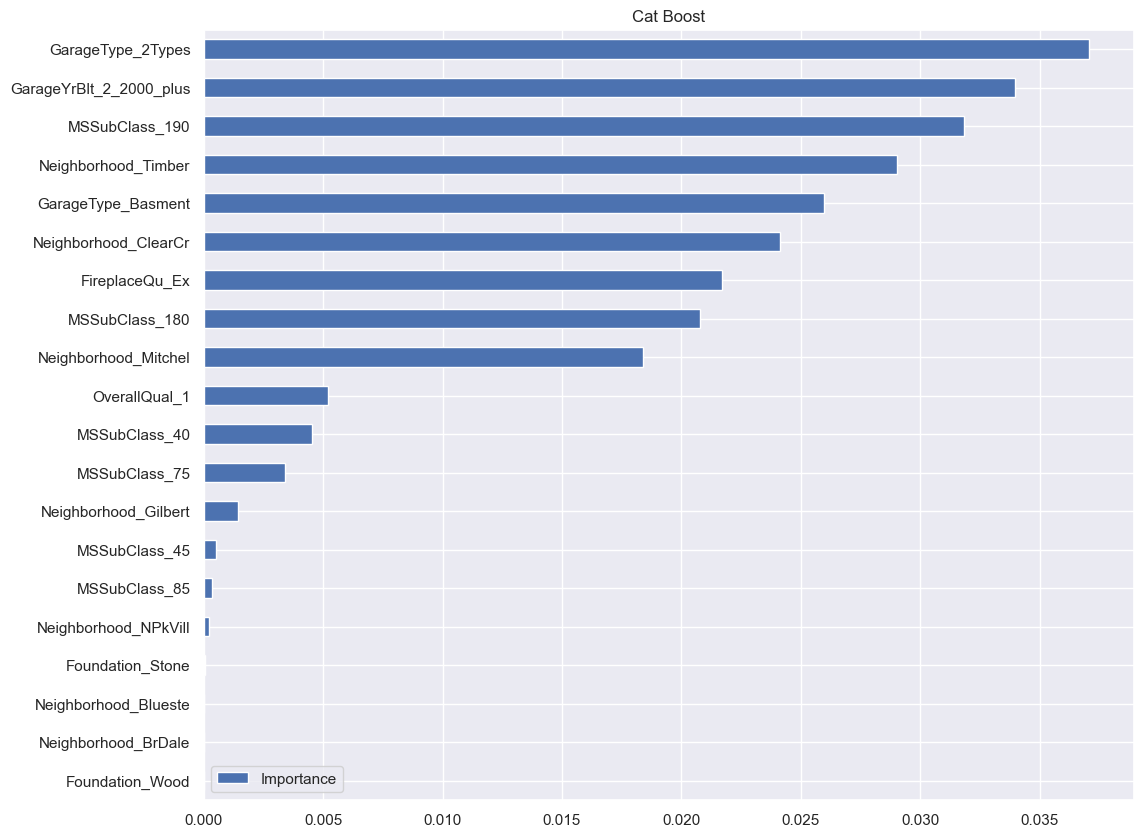

In [238]:
(df_feature_importance
 .sort_values("Importance")
 .head(20)
 .plot(kind="barh", figsize=(12, 10))
)
plt.title("Cat Boost")

# 3. Comparaison des modeles et choix

In [239]:
pd.DataFrame({"Model": model, "train_r2":train_r2, "test_r2":test_r2})

,Model,train_r2,test_r2
0,Regression Linéaire,0.8867,0.8622
1,Regression Lasso,0.7850,0.8115
2,Random Forest,0.9793,0.8428
3,XGBoost,0.9998,0.8104
4,LightGBM,0.9426,0.8427
5,CatBoost,0.9870,0.8594


La comparaison des modèles montrent que les modèles de Bagging et de Boosting ont plus tendance à avoir de meilleur score sur le train, que les autres. Sur le test par contre, ils ont tendance à être moins performant. Ces modèles d'approchent donc un peu plus de l'overfitting que les autres. <br>
La **régression linéaire simple** semble être contre toutes attentes, le meilleur modèle parmi ceux testés. Bien que sa performance sur le train reste un cran en dessous des modèles de boosting, sa performance sur le test est meilleure. De plus, les performances sur le train et sur le test sont très proches. Il y'a donc beaucoup moins de risque d'overfitting. Nous choisirons donc la **régression linéaire simple** 

# 4. Déploiement

In [240]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['YearBuilt', 'TotalBsmtSF',
                                                   '1stFlrSF', 'GrLivArea',
                                                   'FullBath', 'GarageCars',
                                                   'GarageArea']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['OverallQual',
                                                   'Neighborhood', 'ExterQual',
                                                   'BsmtQual', 'KitchenQual',
                                                   'GarageFinish', 'GarageType',
                                                   'MSSubClass', 'FireplaceQu',
                                                   'Foundation',
                                                   'GarageYrBlt_2', 'HeatingQC',
                                                   'BsmtFinType1'])])),
                ('regressor', LinearRegression())])

In [241]:
import pickle

with open('../app/model/best_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

**Simulation app**

In [242]:
import pickle

with open('../app/model/best_model.pkl', 'rb') as model_file:
    best_model = pickle.load(model_file)

In [243]:
val = best_model.predict(X_train.iloc[0:1,])

In [244]:
np.round(np.exp(val[0]),)[0]

371082.0